In [1]:
from __future__ import print_function, division
from builtins import range

In [53]:
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#from mlp_toolkits.mp
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [87]:
class FeatureTransformer:
    def __init__(self, env, n_components = 500):
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)
        
        ## now the observation examples are scaled acrosss their dimensions such that no single dimension dominates the entire learning
        #Use RBF kernerls with different variances to cover different parts of the sample space
        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma= 5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma= 2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma= 1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma= 0.0, n_components=n_components)),
        ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))
        
        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer
        
    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [107]:
class HiddenLayer:
    def __init__(self, M1, M2, f= tf.nn.tanh, use_bias = True, zeros = False):
        if zeros:
            self.W = tf.Variable(tf.zeros(shape = (M1, M2)))
        else:
            self.W = tf.Variable(tf.random_normal(shape=(M1,M2)))
        self.use_bias = use_bias
        
        self.params = self.W
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f
        
    def forward(self, X):
        if self.use_bias:
            return self.f(tf.matmul(X, self.W) + self.b)
        else:
            return self.f(tf.matmul(X, self.W))

In [120]:
class PolicyModel:
    def __init__(self, ft, D, hidden_layer_sizes_mean =[], hidden_layer_sizes_var = []):
        self.ft = ft
        self.D = D
        self.hidden_layer_sizes_mean = hidden_layer_sizes_mean
        self.hidden_layer_sizes_var = hidden_layer_sizes_var
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        
        ##now model the mean
        self.hidden_layers_mean = []
        M1 = D
        for M2 in hidden_layer_sizes_mean:
            layer = HiddenLayer(M1, M2)
            self.hidden_layers_mean.append(layer)
            M1 = M2
            
        #final_layer
        layer = HiddenLayer(M1, 1, lambda x:x, use_bias = False, zeros = True)
        self.hidden_layers_mean.append(layer)
        
        ##now model the variance
        self.var_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_var:
            layer = HiddenLayer(M1, M2)
            self.var_layers.apppend(layer)
            M1 = M2
        
        #final layer
        layer = HiddenLayer(M1,1, tf.nn.softmax, use_bias= False, zeros = False)
        self.var_layers.append(layer)
        
        ### done , now go with the params[weights]
        self.params = []
        for layer in (self.hidden_layers_mean + self.var_layers):
            self.params.append(layer.params)
        
        ####inputs and targets
        self.X = tf.placeholder(tf.float32, shape = (None, D), name =  'X')
        self.actions = tf.placeholder(tf.float32, shape= (None,), name = 'actions')
        self.advantages = tf.placeholder(tf.float32, shape =(None, ), name = 'advantages')
        
        #now outputs
        def get_outputs(layers):
            Z  = self.X
            for layer in layers:
                Z = layer.forward(Z)
            return tf.reshape(Z, [-1])
        
        self.model_mean = get_outputs(self.hidden_layers_mean)
        self.model_var = get_outputs(self.var_layers) + 1e-4  # smoothing
        
        #now make a distribution with this mean, var
        norm= tf.contrib.distributions.Normal(self.model_mean, self.model_var)
        self.predict_op = tf.clip_by_value(norm.sample(),-1, 1) # now this will predict the continous action variable  
        
    def set_session(self, session):
        self.session = session
        
    def init_vars(self):
        init = tf.global_variables_initializer()
        self.session.run(init)
        
    def predict(self, X):
        X = np.atleast_2d(X) # position, velocity
        X = self.ft.transform(X)
        return self.session.run(self.predict_op, feed_dict = {self.X:X}) 
    
    #not sure what sample action does*******
    def sample_action(self, X):
        p = self.predict(X)[0]
        #print(p)
        return p
    
    #jsut copy
    def copy(self):
        clone = PolicyModel(self.ft, self.D, self.hidden_layer_sizes_mean, self.hidden_layer_sizes_var)
        clone.set_session(self.session)
        clone.init_vars()
        clone.copy_from(self)
        return clone
    
    
    
    # will just copy everything from other to self params
    def copy_from(self, other):
        # collect all ops
        ops = []
        my_params = self.params
        other_params = other.params
        print('debugging my params:', my_params)
        print('debugging other params:', other_params)
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            print("debugging p:", p)
            print(type(p))
            op = p.assign(actual)
            ops.append(op)
        self.session.run(op)
    # done with copying
    
    def pertub_params(self):
        ops = []
        for p in self.params:
            v = self.session.run(p)
            noise = np.random.randn(*v.shape)/np.sqrt(v.shape[0]) *5.0
            if np.random.random() < 0.1:
                op = p.assign(noise)
            else:
                op = p.assign(noise+ v)
            ops.append(op)
        self.session.run(ops)

In [136]:
def play_one(env, pmodel, gamma):
    observation = env.reset()
    done = False
    total_reward =0
    iters=  0
    G =0
    while not done and iters<2000:
        action = pmodel.sample_action(observation)
        #print('debugging action sampling:', action)
        observation, reward, done, info= env.step([action]) # exception
        total_reward += reward
        iters+= 1
    return total_reward

In [137]:
def play_multiple_episodes(env, T, pmodel, gamma):
    total_rewards = np.empty(T) # returns new empty array of the shape T
    
    for i in range(T):
        total_rewards[i] = play_one(env, pmodel, gamma)
        
    avg_total_rewards =total_rewards.mean()
    print("total_rewards_avg: ",avg_total_rewards)
    return avg_total_rewards
    

In [138]:
def random_search(env, pmodel, gamma):
    total_rewards = []
    best_total_reward = float('-inf')
    best_pmodel = pmodel
    num_episodes_per_param_test = 3
    for t in range(100):
        tmp_pmodel = best_pmodel.copy()
        tmp_pmodel.pertub_params()
        
        avg_total_rewards = play_multiple_episodes(env, num_episodes_per_param_test, tmp_pmodel, gamma)
        total_rewards.append(avg_total_rewards)
        
        if avg_total_rewards > best_total_reward:
            best_pmodel = tmp_pmodel
            best_total_reward = avg_total_rewards
    return total_rewards, best_pmodel
    

In [139]:
def main():
    env = gym.make('MountainCarContinuous-v0')
    ft = FeatureTransformer(env, n_components = 100)
    D = ft.dimensions
    pmodel = PolicyModel(ft, D, [], [])
    session = tf.InteractiveSession()
    
    pmodel.set_session(session)
    pmodel.init_vars()
    gamma = 0.99
    
    env = wrappers.Monitor(env, '../neural_gym_videos')
    total_rewards , best_pmodel = random_search(env, pmodel, gamma)
    plt.plot(total_rewards)
    plt.show()
    
    #now check if the pmodel is good enough
    total_rewards = play_multiple_episodes(env, 100, pmodel, gamma)
    plt.plot(total_rewards)
    plt.show()
    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
debugging my params: [<tf.Variable 'Variable_56:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_57:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_54:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_55:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_56:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_57:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -52.620886377400495
debugging my params: [<tf.Variable 'Variable_58:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_59:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_56:0' s

total_rewards_avg:  -52.61737959423943
debugging my params: [<tf.Variable 'Variable_84:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_85:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_72:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_73:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_84:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_85:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -54.814837935842114
debugging my params: [<tf.Variable 'Variable_86:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_87:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_72:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_73:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_86:0' shape=(400, 1) dtyp

total_rewards_avg:  -59.18318919843019
debugging my params: [<tf.Variable 'Variable_112:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_113:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_108:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_109:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_112:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_113:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  76.59714470554452
debugging my params: [<tf.Variable 'Variable_114:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_115:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_112:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_113:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_114:0' shape=(400

debugging p: <tf.Variable 'Variable_139:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -54.494635649827764
debugging my params: [<tf.Variable 'Variable_140:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_141:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_112:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_113:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_140:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_141:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -59.14616301713394
debugging my params: [<tf.Variable 'Variable_142:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_143:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_112:0' shape=(400, 1) dtype=fl

total_rewards_avg:  -18.13100569638049
debugging my params: [<tf.Variable 'Variable_168:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_169:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_112:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_113:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_168:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_169:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -71.08657841233129
debugging my params: [<tf.Variable 'Variable_170:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_171:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_112:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_113:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_170:0' shape=(40

total_rewards_avg:  30.577212771230524
debugging my params: [<tf.Variable 'Variable_196:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_197:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_178:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_179:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_196:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_197:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -52.82772951966933
debugging my params: [<tf.Variable 'Variable_198:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_199:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_178:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_179:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_198:0' shape=(40

total_rewards_avg:  -58.39497884272402
debugging my params: [<tf.Variable 'Variable_224:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_225:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_178:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_179:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_224:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_225:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -53.696610799696806
debugging my params: [<tf.Variable 'Variable_226:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_227:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_178:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_179:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_226:0' shape=(4

total_rewards_avg:  -51.1719856632929
debugging my params: [<tf.Variable 'Variable_252:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_253:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_248:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_249:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_252:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
debugging p: <tf.Variable 'Variable_253:0' shape=(400, 1) dtype=float32_ref>
<class 'tensorflow.python.ops.variables.Variable'>
total_rewards_avg:  -54.20787788937913
debugging my params: [<tf.Variable 'Variable_254:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_255:0' shape=(400, 1) dtype=float32_ref>]
debugging other params: [<tf.Variable 'Variable_248:0' shape=(400, 1) dtype=float32_ref>, <tf.Variable 'Variable_249:0' shape=(400, 1) dtype=float32_ref>]
debugging p: <tf.Variable 'Variable_254:0' shape=(400

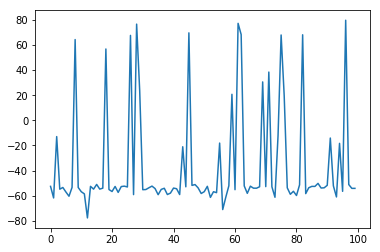

total_rewards_avg:  -49.465449607823345


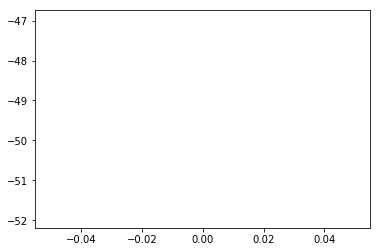

In [140]:
main()